## Mounting the drive in colab

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Importing Dataset

In [2]:
from os import getcwd,listdir
from os.path import join
curr_dir = getcwd()
dataset_dir = join(curr_dir,'drive','MyDrive','Codalab','Meme Classification Challenge','Dataset')
train_img_dir_path = join(dataset_dir,'training_img')
train_df_path = join(dataset_dir,'labels.csv')
test_img_dir_path = join(dataset_dir,'test_img')
test_df_path = join(dataset_dir,'test_captions.csv')

## Importing Necessary Packages

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import random
import cv2
import PIL.Image as Image
from pylab import rcParams
from matplotlib import rc
from matplotlib.ticker import MaxNLocator
from torch.optim import lr_scheduler
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from torch import nn, optim
import torch.nn.functional as F
import torchvision.transforms as T
from torch.utils.data import DataLoader,SubsetRandomSampler
from torchvision import models
from collections import defaultdict
import os

## configuring our setup

In [4]:
%matplotlib inline
%config InlineBackend.figure_format='retina'

sns.set(style='darkgrid', palette='muted', font_scale=1.2)

HAPPY_COLORS_PALETTE = ["#01BEFE", "#FFDD00", "#FF7D00", "#FF006D", "#ADFF02", "#8F00FF"]

sns.set_palette(sns.color_palette(HAPPY_COLORS_PALETTE))

rcParams['figure.figsize'] = 16, 12

seed_val = 42
random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)

In [5]:
if torch.cuda.is_available():    

    # Tell PyTorch to use the GPU.    
    device = torch.device("cuda")

    print('There are %d GPU(s) available.' % torch.cuda.device_count())

    print('We will use the GPU:', torch.cuda.get_device_name(0))

# If not...
else:
    print('No GPU available, using the CPU instead.')
    device = torch.device("cpu")

There are 1 GPU(s) available.
We will use the GPU: Tesla T4


### Dataset Inspection

In [6]:
print(f" No. of training images : {len(listdir(train_img_dir_path))}")
print(f" No. of test images: {len(listdir(test_img_dir_path))}")

 No. of training images : 2300
 No. of test images: 667


In [7]:
train_df = pd.read_csv(train_df_path)
train_df.sample(10)

,imagename,captions,labels
741,Not_troll_75.jpg,romba varuthapada vendiya vishiyam dhaan...,Not_troll
1917,troll_1854.jpg,YAARELLAM VELAIYADI IRUKKINGA...,troll
208,Not_troll_27.jpg,ippayellam nalladhuke kaalam illaa...,Not_troll
1546,troll_152.jpg,LOOSU KO MARIE PESADHA DHANASEKARA....!,troll
282,Not_troll_336.jpg,paarithu pala naatkal aairuchi.. nalla irukkir...,Not_troll
479,Not_troll_513.jpg,yenna boss ipidi aagiduchi..,Not_troll
1080,troll_1053.jpg,YAARU MUDHALLA VEETUKKU PORADHU YENUDU PAARPAM...,troll
1891,troll_1830.jpg,SURIYA VAMSAM THEVAYANI~ SARATHKUMAR'KU APPURA...,troll
111,Not_troll_182.jpg,idhellam oru page ah??,Not_troll
2085,troll_25.jpg,Cross salary net salary,troll


In [8]:
!nvidia-smi

Thu Jan  7 11:14:55 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.27.04    Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   49C    P8    10W /  70W |     10MiB / 15079MiB |      0%      Default |
|                               |                      |                 ERR! |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

## Conversion of Labels

In [9]:
train_df['labels'].value_counts()

troll        1282
Not_troll    1018
Name: labels, dtype: int64

In [10]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
train_df['labels'] = le.fit_transform(train_df['labels'])

In [11]:
train_df['labels'].value_counts()

1    1282
0    1018
Name: labels, dtype: int64

In [12]:
class_names = ['Not_troll','troll']
label_dict = {0:'Not_troll',1:'troll'}

In [13]:
train_df

,imagename,captions,labels
0,Not_troll_0.jpg,Ada pikkalipayalugala,0
1,Not_troll_1.jpg,Etho sambavam nadandhirukkum pola,0
2,Not_troll_10.jpg,Vunnayellam frienda vechirukken paaru,0
3,Not_troll_100.jpg,Idho! Ivan dhaan naan nasama ponadhukku kaaranam,0
4,Not_troll_1000.jpg,Ennada lusu thanama pesikittu irukka lusu payale,0
...,...,...,...
2295,troll_439.jpg,amma yaaro orutharu... pattu paaduraaruma......,1
2296,troll_44.jpg,Phone n Twitter hacked please don't respond ...,1
2297,troll_440.jpg,Respected deat @narendramodi ji hearty corigr...,1
2298,troll_441.jpg,Engu irutha nan mnnil piranthidum bothu vera...,1


In [14]:
train_df.to_csv(join(dataset_dir,'final_train.csv'),index = False)

In [15]:
final_train = pd.read_csv(join(dataset_dir,'final_train.csv'))
final_train

,imagename,captions,labels
0,Not_troll_0.jpg,Ada pikkalipayalugala,0
1,Not_troll_1.jpg,Etho sambavam nadandhirukkum pola,0
2,Not_troll_10.jpg,Vunnayellam frienda vechirukken paaru,0
3,Not_troll_100.jpg,Idho! Ivan dhaan naan nasama ponadhukku kaaranam,0
4,Not_troll_1000.jpg,Ennada lusu thanama pesikittu irukka lusu payale,0
...,...,...,...
2295,troll_439.jpg,amma yaaro orutharu... pattu paaduraaruma......,1
2296,troll_44.jpg,Phone n Twitter hacked please don't respond ...,1
2297,troll_440.jpg,Respected deat @narendramodi ji hearty corigr...,1
2298,troll_441.jpg,Engu irutha nan mnnil piranthidum bothu vera...,1


In [16]:
test_df = pd.read_csv(test_df_path)
test_df = test_df.drop('Unnamed: 0',axis = 1)
test_df.sample(10)

,imagename,captions
52,test_img_52.jpg,Biggboss season 1:kunthani GAYATHRI biggboss ...
196,test_img_196.jpg,amma innakki yenna soru? kari soru koli ka...
320,test_img_320.jpg,rcb changed their jersey colour *me: jersey...
236,test_img_236.jpg,during project review developer ivardhaan a...
628,test_img_628.jpg,NE ENNAIKU PURIYURA MARI PESURIYO ANNAIKU THAN...
165,test_img_165.jpg,~ when i see this cover aiyo namma kai vera s...
599,test_img_599.jpg,my first thought if some girl gives me friend ...
627,test_img_627.jpg,"KALYANAM AAGATHAVARKU PRESTIGE YENDRAL, KOVRAV..."
322,test_img_322.jpg,indha vilaiyattu neyabagam iruka? oru kudam th...
395,test_img_395.jpg,sherin va namma vera zone ku polam *audience:...


In [17]:
class MemesDataset(torch.utils.data.Dataset):
    def __init__(self, csv_file, root_dir_path, transform=None,flg = True):
        ## flag for training or test (defaul true for training set)
        self.flg = flg
        ## reading the dataframe
        self.dataframe = pd.read_csv(csv_file)
        ## getting the root_dir_path
        self.root_dir_path = root_dir_path
        ## getting imageids from the dataframe
        self.imagenames = self.dataframe["imagename"]
        ## getting all captions from the dataframe
        # self.captions = self.dataframe["captions"]
        ## getting labels from the dataset if the dataset is training type
        if self.flg:
          self.labels = self.dataframe["labels"]
        ## getting possible transformations of the images
        self.transform = transform


    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, index):
        ## get the imagename from the dataframe
        imagename = self.imagenames[index]
        ## get the path of the image        
        img_path = os.path.join(self.root_dir_path,imagename)
        ## open the image using PIL.Image and convert it to RGB in case of an extra alpha channel
        image = Image.open(img_path).convert('RGB')
        ## applying transformations to image
        if self.transform:
          image = self.transform(image)
        ## return y label if dataset type is training
        if self.flg:
          y_label = torch.tensor(int(self.dataframe.iloc[index, 2]))
          return (image, y_label)

        return image  

## Data Transforms

In [18]:
mean_nums = [0.485, 0.456, 0.406]
std_nums = [0.229, 0.224, 0.225]
img_size = 299

In [19]:
train_transforms = T.Compose([
                            T.RandomResizedCrop(size=img_size),
                            T.ToTensor(),
                            T.Normalize(mean_nums, std_nums)
                  ])

test_transforms =  T.Compose([
                            T.RandomResizedCrop(size=img_size),
                            T.ToTensor(),
                            T.Normalize(mean_nums, std_nums)
                ])


## Loading our datasets

In [20]:
train_dataset = MemesDataset(join(dataset_dir,'final_train.csv'),train_img_dir_path,train_transforms)
test_dataset = MemesDataset(join(dataset_dir,'test_captions.csv'),test_img_dir_path,test_transforms,flg = False)

## Creating dataloaders

In [35]:

batch_size = 128
validation_split = .2
shuffle_dataset = True

# Creating data indices for training and validation splits:
train_dataset_size = len(train_dataset)
indices = list(range(train_dataset_size))
split = int(np.floor(validation_split * train_dataset_size))

if shuffle_dataset :
    np.random.seed(seed_val)
    np.random.shuffle(indices)

train_indices, val_indices = indices[split:], indices[:split]

# Creating PT data samplers and loaders:
train_sampler = SubsetRandomSampler(train_indices)
valid_sampler = SubsetRandomSampler(val_indices)


train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, 
                                           sampler=train_sampler)
validation_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size,
                                                sampler=valid_sampler)

test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size)

## Helper function for training epoch

In [37]:
def train_epoch(
  model, 
  data_loader, 
  criterion, 
  optimizer, 
  device, 
  scheduler, 
  n_examples
):
  model = model.train()

  losses = []
  correct_predictions = 0
  print(f'Doing training on {n_examples} samples')
  for batch_idx , (inputs, labels) in enumerate(data_loader):
    print(f' Processing batch {batch_idx+1} ')
    inputs = inputs.to(device)
    labels = labels.to(device)

    outputs, aux_outputs = model(inputs)
    loss1 = criterion(outputs, labels)
    loss2 = criterion(aux_outputs, labels)
    # outputs = model(inputs)
    # loss = criterion(outputs,labels)
    loss = loss1 + 0.4*loss2
    _, preds = torch.max(outputs, 1)
    correct_predictions += torch.sum(preds == labels)
    losses.append(loss.item())
  
    loss.backward()
    optimizer.step()
    optimizer.zero_grad()

  scheduler.step()

  return correct_predictions.double() / n_examples, np.mean(losses)

## Helper function for validation loop

In [38]:
def eval_model(
    model, 
    data_loader,
    criterion,
    device,
    n_examples):
  model = model.eval()

  losses = []
  correct_predictions = 0
  print(f'Doing validation on {n_examples} samples')
  with torch.no_grad():
    for batch_idx ,(inputs, labels) in enumerate(data_loader):
      print(f' Processing batch {batch_idx+1} ')
      inputs = inputs.to(device)
      labels = labels.to(device)

      outputs = model(inputs)
      loss = criterion(outputs, labels)
     
      _, preds = torch.max(outputs, dim=1)

      correct_predictions += torch.sum(preds == labels)
      losses.append(loss.item())

  return correct_predictions.double() / n_examples, np.mean(losses)

## Helper function to train model

In [39]:
def train_model(
    model,
    train_data_loader,
    val_data_loader, 
    train_dataset_size,
    val_dataset_size,
    device, 
    n_epochs=3):
  
  optimizer = optim.AdamW(model.parameters(), lr=0.001)
  
  scheduler = lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)
  
  criterion = nn.CrossEntropyLoss().to(device)

  history = defaultdict(list)
  best_accuracy = 0

  for epoch in range(n_epochs):

    print(f'Epoch {epoch + 1}/{n_epochs}')
    print('-' * 10)

    train_acc, train_loss = train_epoch(
                                model, 
                                train_data_loader, 
                                criterion, 
                                optimizer, 
                                device, 
                                scheduler, 
                                train_dataset_size
                            )

    print(f'Train loss {train_loss} accuracy {train_acc}')

    val_acc, val_loss = eval_model(
                                model, 
                                val_data_loader, 
                                criterion, 
                                device, 
                                val_dataset_size
                        )

    print(f'Val   loss {val_loss} accuracy {val_acc}')
    print()

    history['train_acc'].append(train_acc)
    history['train_loss'].append(train_loss)
    history['val_acc'].append(val_acc)
    history['val_loss'].append(val_loss)

    if val_acc > best_accuracy:
      torch.save(model.state_dict(), 'best_model_state.bin')
      best_accuracy = val_acc

  print(f'Best val accuracy: {best_accuracy}')
  
  model.load_state_dict(torch.load('best_model_state.bin'))

  return model, history

## Defining our model

In [40]:
def set_parameter_requires_grad(model, feature_extracting):
    if feature_extracting:
        for param in model.parameters():
            param.requires_grad = False

In [41]:
num_classes = 2
feature_extract = True
use_pretrained = True

model = models.inception_v3(pretrained=use_pretrained)
set_parameter_requires_grad(model, feature_extract)

# model = models.inception_v3(pretrained=use_pretrained)
# set_parameter_requires_grad(model, feature_extract)


# Handle the auxilary net
num_ftrs = model.AuxLogits.fc.in_features
model.AuxLogits.fc = nn.Linear(num_ftrs, num_classes)


# Handle the primary net
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs,num_classes)


model.to(device)

Inception3(
  (Conv2d_1a_3x3): BasicConv2d(
    (conv): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), bias=False)
    (bn): BatchNorm2d(32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (Conv2d_2a_3x3): BasicConv2d(
    (conv): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (Conv2d_2b_3x3): BasicConv2d(
    (conv): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (maxpool1): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  (Conv2d_3b_1x1): BasicConv2d(
    (conv): Conv2d(64, 80, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(80, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (Conv2d_4a_3x3): BasicConv2d(
    (conv): Conv2d(80, 192, kernel_size=(3, 3), stri

In [42]:
train_size = len(train_dataset) - split 
val_size = split

In [43]:
print(f'The training set size is {train_size} and validation set size is {val_size}')

The training set size is 1840 and validation set size is 460


## Model training

In [44]:
model, history = train_model(model, train_loader,validation_loader, train_size,val_size, device)

Epoch 1/3
----------
Doing training on 1840 samples
 Processing batch 1 
 Processing batch 2 
 Processing batch 3 
 Processing batch 4 
 Processing batch 5 
 Processing batch 6 
 Processing batch 7 
 Processing batch 8 
 Processing batch 9 
 Processing batch 10 
 Processing batch 11 
 Processing batch 12 
 Processing batch 13 
 Processing batch 14 
 Processing batch 15 
Train loss 0.8839347918828329 accuracy 0.5798913043478261
Doing validation on 460 samples
 Processing batch 1 
 Processing batch 2 
 Processing batch 3 
 Processing batch 4 
Val   loss 0.5772762596607208 accuracy 0.7630434782608696

Epoch 2/3
----------
Doing training on 1840 samples
 Processing batch 1 
 Processing batch 2 
 Processing batch 3 
 Processing batch 4 
 Processing batch 5 
 Processing batch 6 
 Processing batch 7 
 Processing batch 8 
 Processing batch 9 
 Processing batch 10 
 Processing batch 11 
 Processing batch 12 
 Processing batch 13 
 Processing batch 14 
 Processing batch 15 
Train loss 0.70510379

## Helper function for plotting training history

In [45]:
def plot_training_history(history):
  fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 6))

  ax1.plot(history['train_loss'], label='train loss')
  ax1.plot(history['val_loss'], label='validation loss')

  ax1.xaxis.set_major_locator(MaxNLocator(integer=True))
  ax1.set_ylim([-0.05, 1.05])
  ax1.legend()
  ax1.set_ylabel('Loss')
  ax1.set_xlabel('Epoch')

  ax2.plot(history['train_acc'], label='train accuracy')
  ax2.plot(history['val_acc'], label='validation accuracy')

  ax2.xaxis.set_major_locator(MaxNLocator(integer=True))
  ax2.set_ylim([-0.05, 1.05])
  ax2.legend()

  ax2.set_ylabel('Accuracy')
  ax2.set_xlabel('Epoch')

  fig.suptitle('Training history')

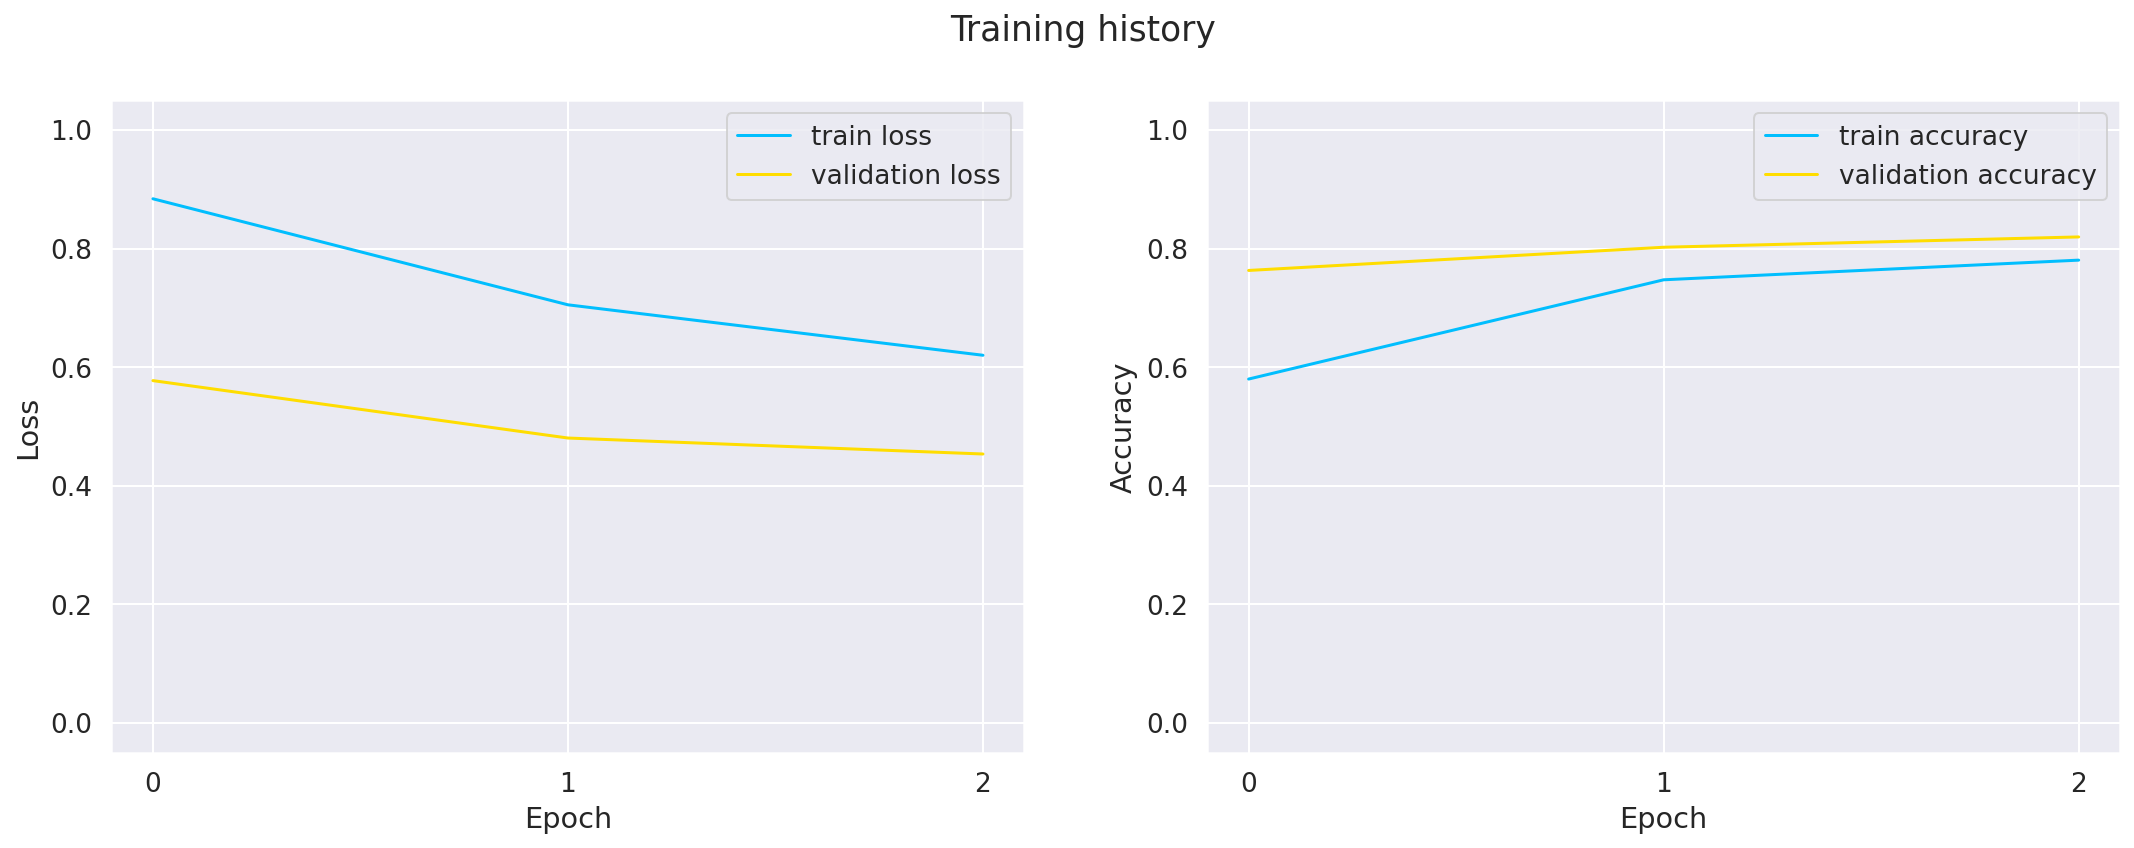

In [46]:
plot_training_history(history)

## Helper function to get the predictions from train and validation sets

In [47]:
def get_predictions(model, data_loader):
  model = model.eval()
  predictions = []
  real_values = []
  with torch.no_grad():
    for inputs, labels in data_loader:
      inputs = inputs.to(device)
      labels = labels.to(device)

      outputs = model(inputs)
      _, preds = torch.max(outputs, 1)
      predictions.extend(preds)
      real_values.extend(labels)
  predictions = torch.as_tensor(predictions).cpu()
  real_values = torch.as_tensor(real_values).cpu()
  return predictions, real_values

## Confusion Matrix Helper function

In [48]:
def show_confusion_matrix(confusion_matrix, class_names):

  cm = confusion_matrix.copy()

  cell_counts = cm.flatten()

  cm_row_norm = cm / cm.sum(axis=1)[:, np.newaxis]

  row_percentages = ["{0:.2f}".format(value) for value in cm_row_norm.flatten()]

  cell_labels = [f"{cnt}\n{per}" for cnt, per in zip(cell_counts, row_percentages)]
  cell_labels = np.asarray(cell_labels).reshape(cm.shape[0], cm.shape[1])

  df_cm = pd.DataFrame(cm_row_norm, index=class_names, columns=class_names)

  hmap = sns.heatmap(df_cm, annot=cell_labels, fmt="", cmap="Blues")
  hmap.yaxis.set_ticklabels(hmap.yaxis.get_ticklabels(), rotation=0, ha='right')
  hmap.xaxis.set_ticklabels(hmap.xaxis.get_ticklabels(), rotation=30, ha='right')
  plt.ylabel('True Sign')
  plt.xlabel('Predicted Sign');

## Performance on training set

In [49]:
y_pred, y_test = get_predictions(model, train_loader)
print(classification_report(y_test, y_pred, target_names=class_names))

              precision    recall  f1-score   support

   Not_troll       0.80      0.88      0.84       816
       troll       0.89      0.82      0.86      1024

    accuracy                           0.85      1840
   macro avg       0.85      0.85      0.85      1840
weighted avg       0.85      0.85      0.85      1840



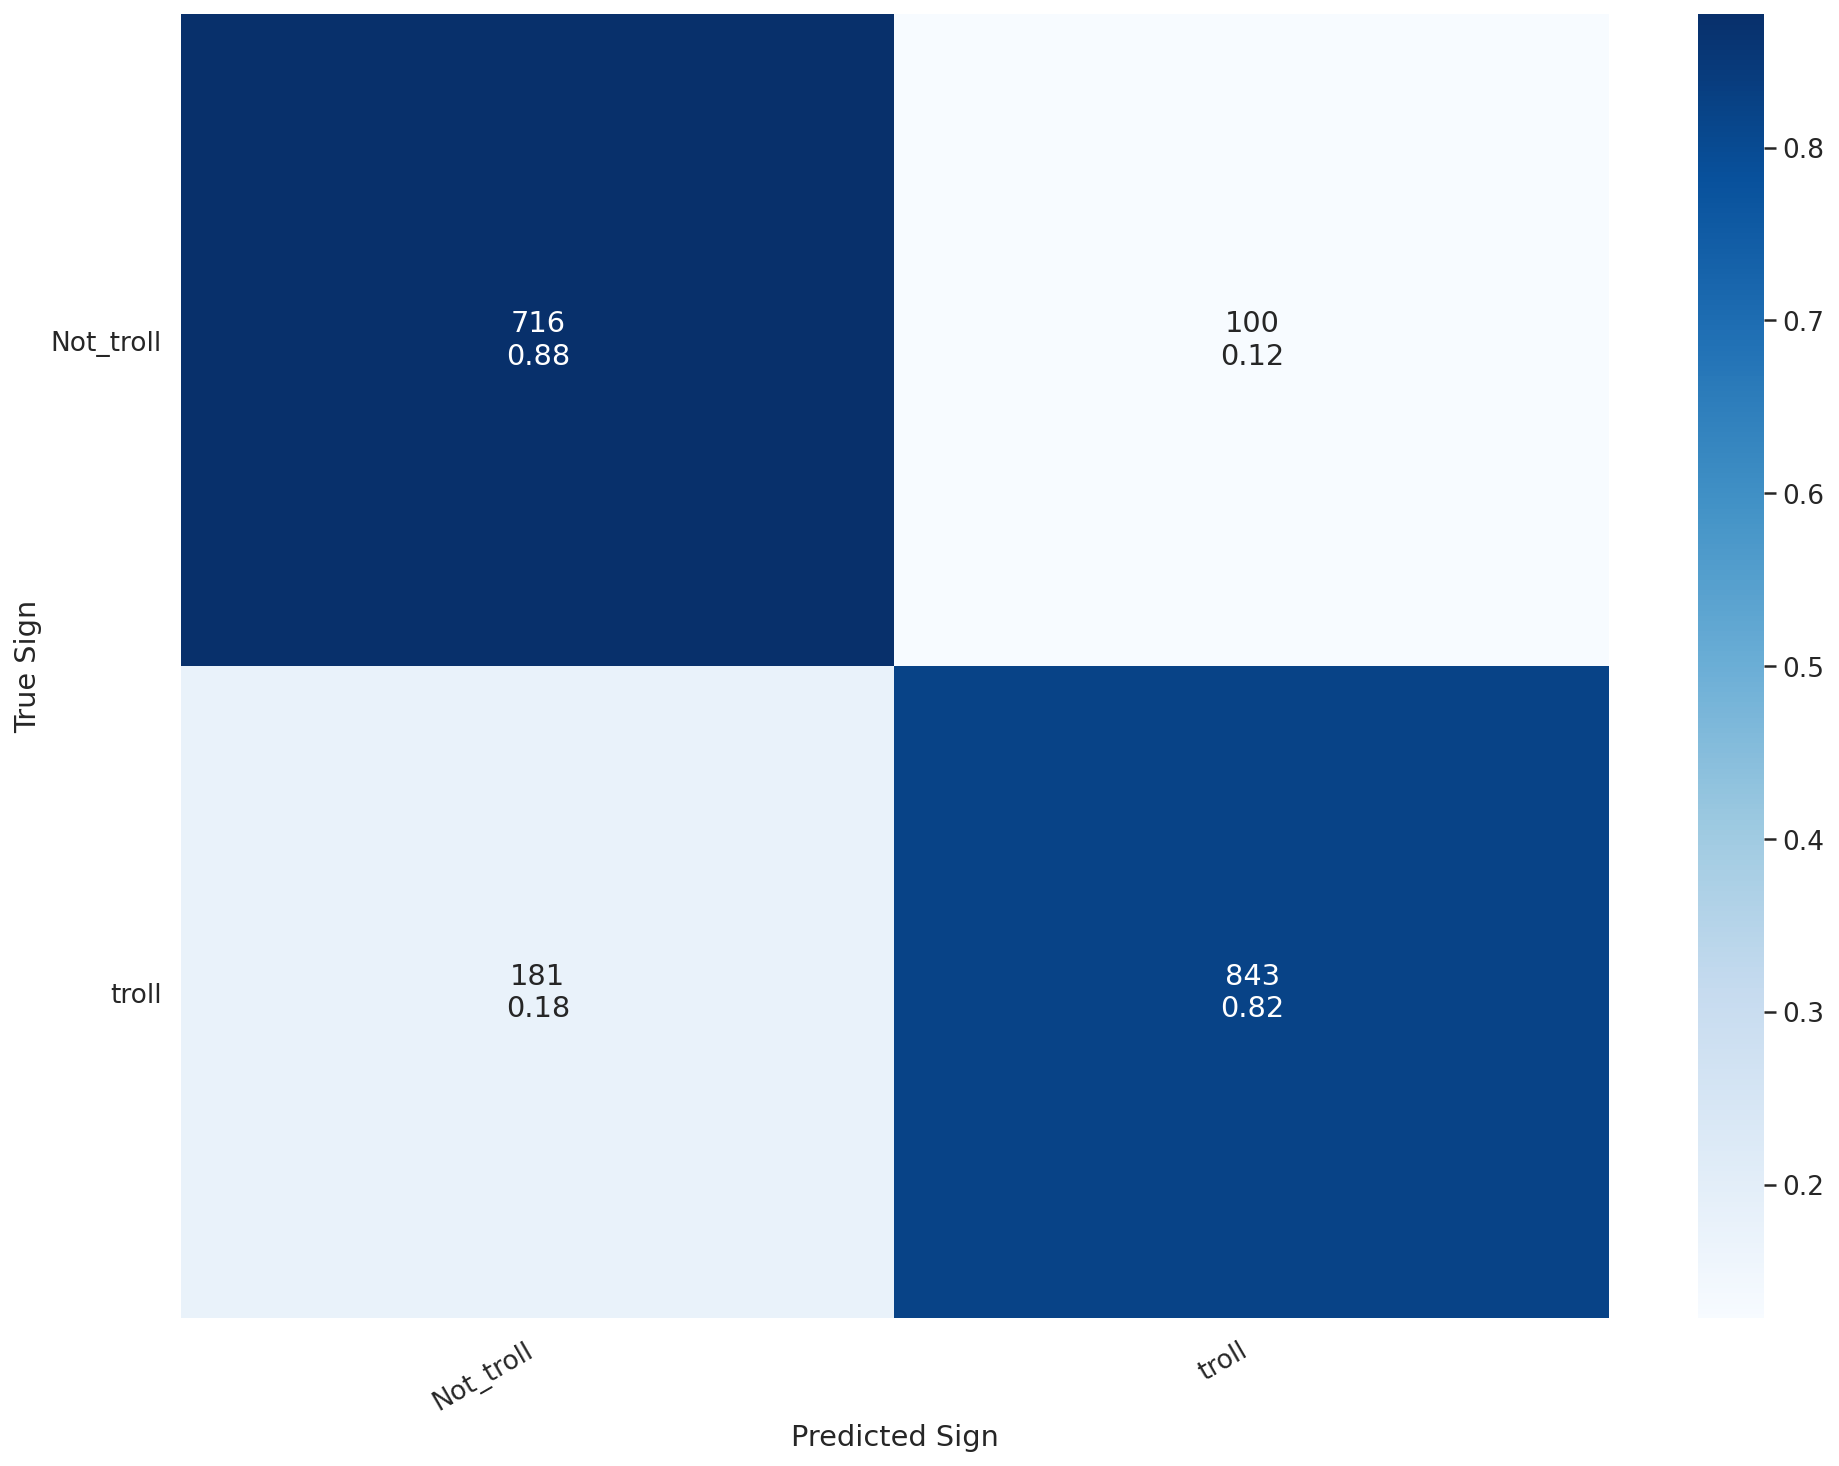

In [50]:
cm = confusion_matrix(y_test, y_pred)
show_confusion_matrix(cm, class_names)

## Performance on validation set

In [51]:
y_pred, y_test = get_predictions(model, validation_loader)
print(classification_report(y_test, y_pred, target_names=class_names))

              precision    recall  f1-score   support

   Not_troll       0.77      0.85      0.80       202
       troll       0.87      0.80      0.83       258

    accuracy                           0.82       460
   macro avg       0.82      0.82      0.82       460
weighted avg       0.82      0.82      0.82       460



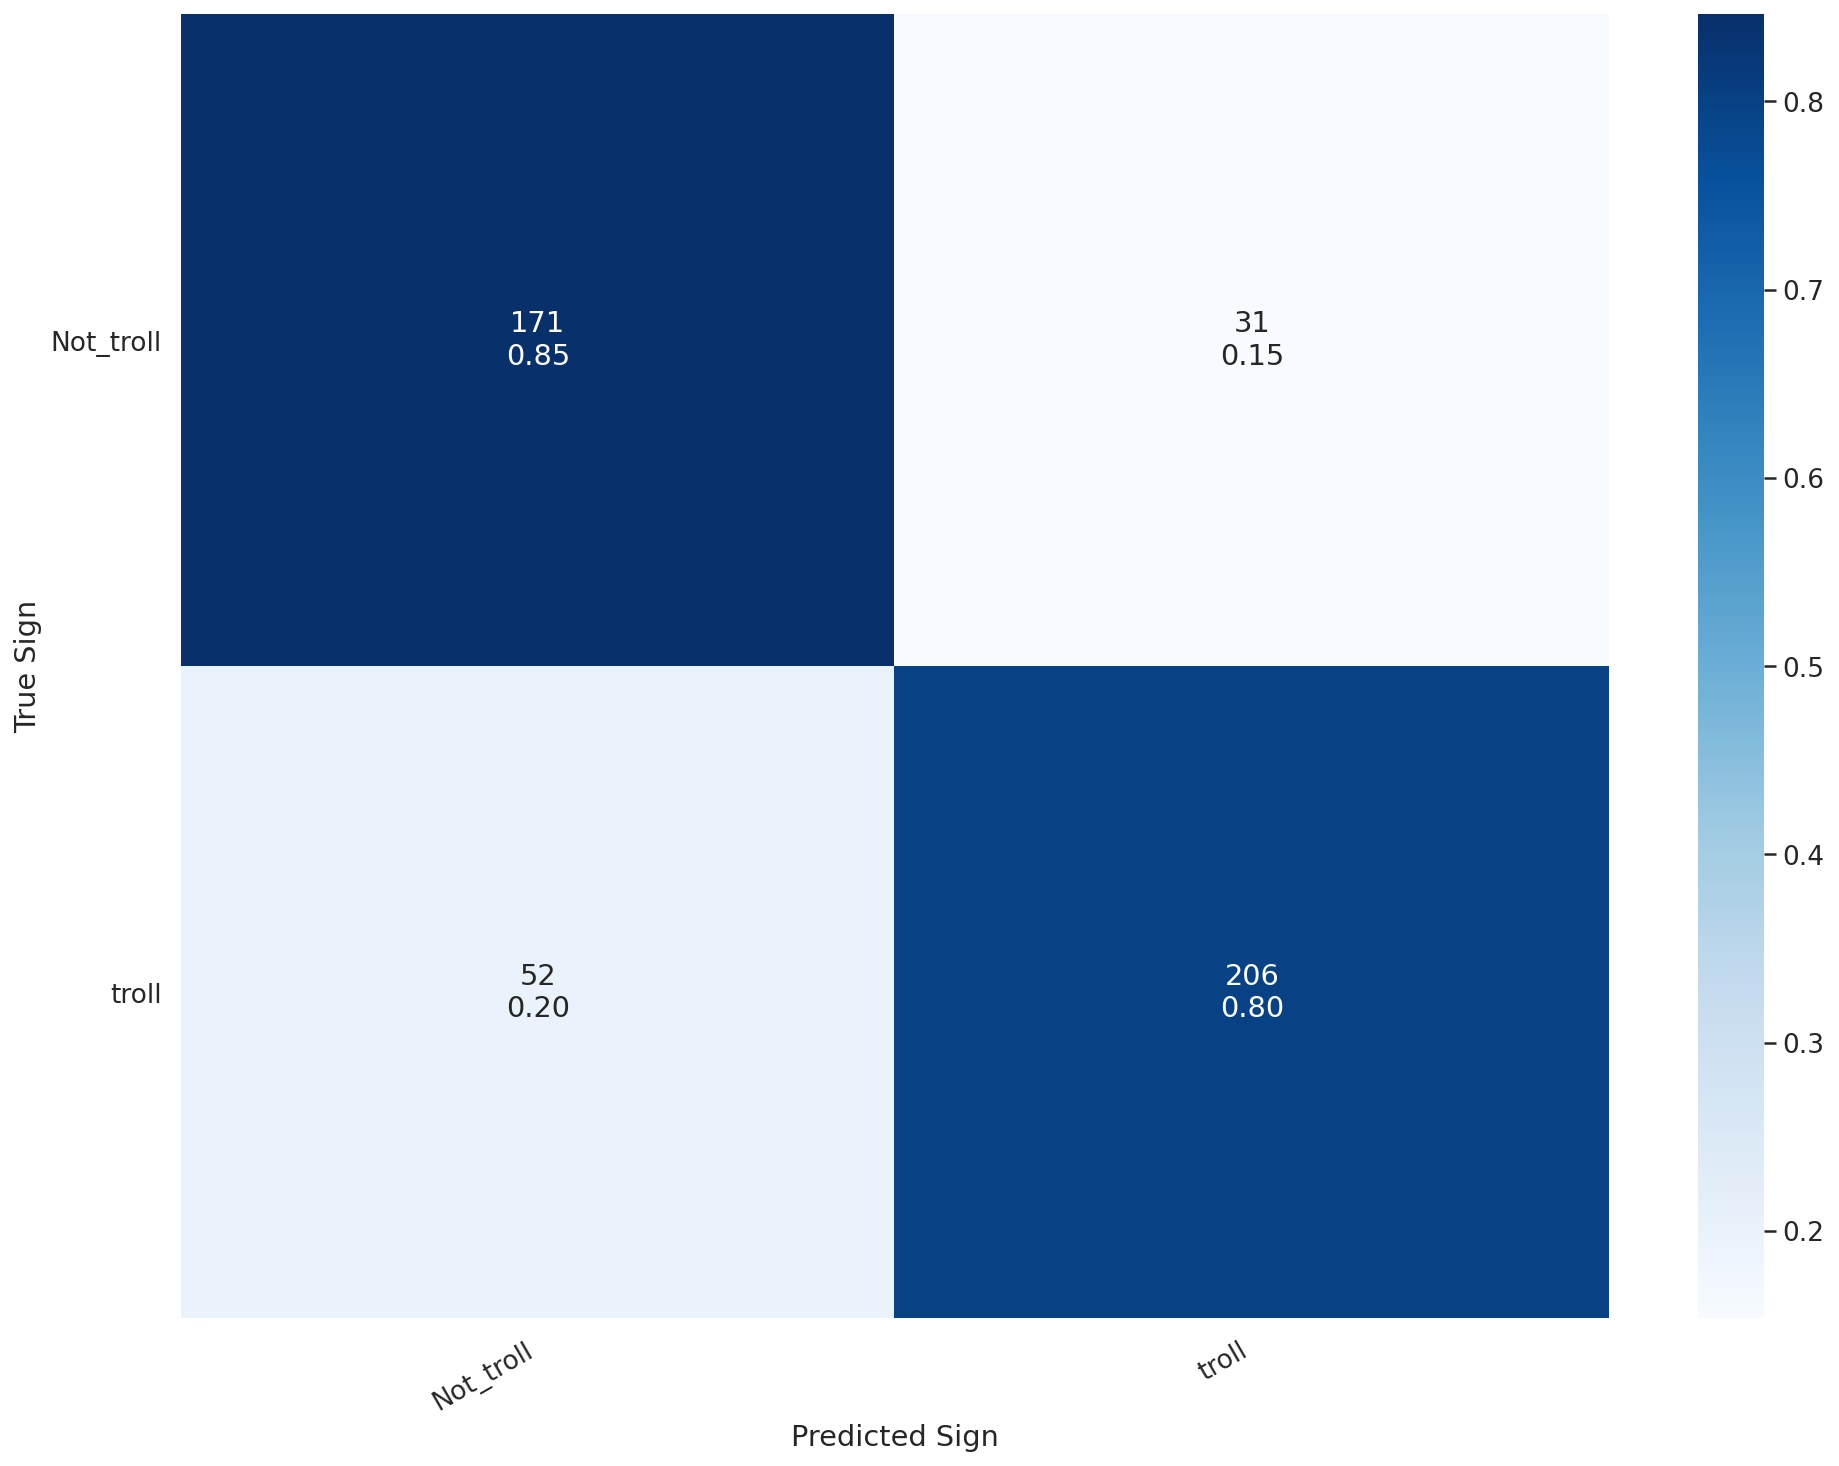

In [52]:
cm = confusion_matrix(y_test, y_pred)
show_confusion_matrix(cm, class_names)

## Saving the model

In [53]:
torch.save(model,join(curr_dir,'drive','MyDrive','Codalab','Meme Classification Challenge','Models','tamil_memes_classification_pytorch_inceptionv3'))

## Helper function to get the predictions on the test set (with unknown labels)

In [56]:
def get_test_predictions(model, data_loader):
  model = model.eval()
  predictions = []
  print('Predicting on test dataset')
  with torch.no_grad():
    for idx , (inputs) in enumerate(data_loader):
      print(f'Predicting on batch {idx + 1}')
      inputs = inputs.to(device)

      outputs = model(inputs)

      _, preds = torch.max(outputs, 1)
      
      predictions.extend(preds)
  predictions = torch.as_tensor(predictions).cpu()
  return predictions

## Getting test set predictions

In [57]:
y_pred = get_test_predictions(model, test_loader)
y_pred

Predicting on test dataset
Predicting on batch 1
Predicting on batch 2
Predicting on batch 3
Predicting on batch 4
Predicting on batch 5
Predicting on batch 6


tensor([0, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1,
        0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1,
        1, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0,
        0, 1, 0, 0, 1, 1, 0, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1,
        1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 1, 1, 1, 1,
        1, 1, 1, 0, 1, 0, 0, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1,
        1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1,
        1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1,
        1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1,
        0, 1, 1, 0, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1,
        1, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1,
        0, 1, 0, 1, 1, 1, 0, 0, 1, 1, 1,

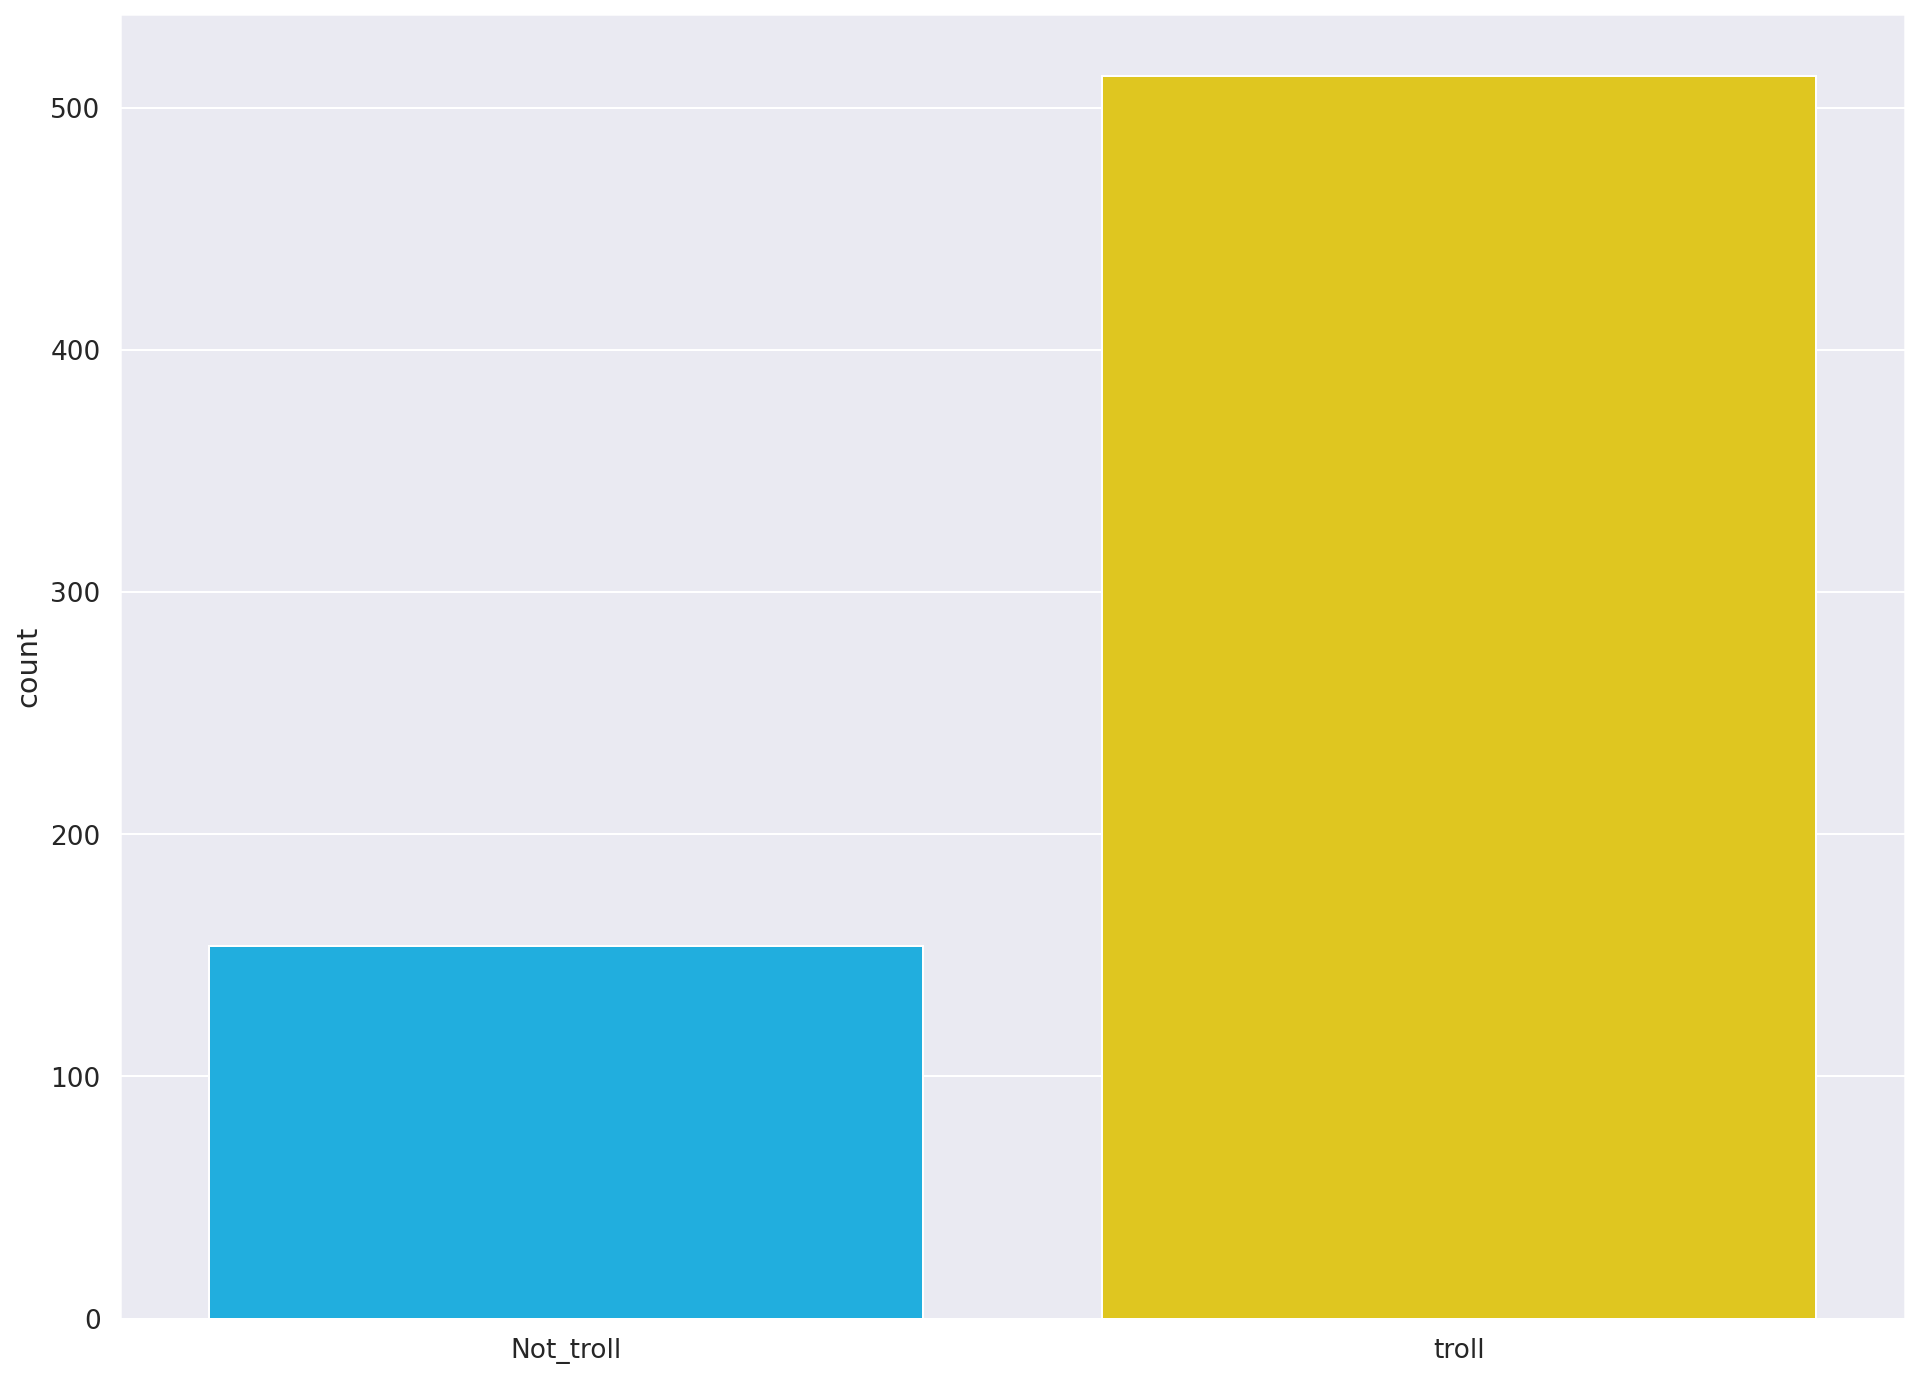

In [58]:
sns.countplot(x = le.inverse_transform(y_pred))